<a href="https://colab.research.google.com/github/mahi29patel/Customer-Segmentation/blob/main/Customer_classification_bigdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Customer classification: Myntra Hackerramp**

Installing pyspark

In [2]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=8aa405df27bacad0529208f3759aa726fbabb0f845109eb9379fd046e9388158
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


Import the libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')
from pyspark.sql import SparkSession

Initialize spark session

In [5]:
spark = SparkSession.builder.appName("Customer segmentation").getOrCreate()

Creating a data frame

In [6]:
df = spark.read.csv('data.csv',header=True,escape="\"")

In [7]:
df.show(5,0)

+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate   |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/2010 8:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/2010 8:26|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|
+---------+---------+-----------------------------------

### Analysing data to know about the data points

Number of rows

In [8]:
df.count()

541909

Distinct customers in dataframe

In [9]:
df.select('CustomerID').distinct().count()

4373

Find the country from which most purchases are made

In [11]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show()

+---------------+-------------+
|        Country|country_count|
+---------------+-------------+
| United Kingdom|         3950|
|        Germany|           95|
|         France|           87|
|          Spain|           31|
|        Belgium|           25|
|    Switzerland|           21|
|       Portugal|           19|
|          Italy|           15|
|        Finland|           12|
|        Austria|           11|
|         Norway|           10|
|        Denmark|            9|
|Channel Islands|            9|
|      Australia|            9|
|    Netherlands|            9|
|         Sweden|            8|
|         Cyprus|            8|
|          Japan|            8|
|         Poland|            6|
|         Greece|            4|
+---------------+-------------+
only showing top 20 rows



Find when the latest purchase

In [15]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df = df.withColumn('date',to_timestamp("InvoiceDate", 'dd/M/yyyy HH:mm'))
df.select(max("date")).show()

+-------------------+
|          max(date)|
+-------------------+
|2011-12-10 17:19:00|
+-------------------+



Find the earliest purchase made by customer

In [16]:
df.select(min("date")).show()

+-------------------+
|          min(date)|
+-------------------+
|2010-01-12 08:26:00|
+-------------------+



### Data pre-processing

In [17]:
df.show(5,0)

+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate   |UnitPrice|CustomerID|Country       |date               |
+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+-------------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/2010 8:26|2.55     |17850     |United Kingdom|2010-01-12 08:26:00|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|2010-01-12 08:26:00|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/2010 8:26|2.75     |17850     |United Kingdom|2010-01-12 08:26:00|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|2010-01-12 08:26:00|
|536365   |84029E   |RED WOOLLY HO

Deriving 3 features - recency, frequency, and monetary value (RFM)

Recency

In [24]:
df = df.withColumn("from_date", lit("2010-01-12 08:26:00"))
df = df.withColumn('from_date',to_timestamp("from_date", 'yyyy-MM-dd HH:mm:ss'))

df2 = df.withColumn('recency',col("date").cast("long") - col('from_date').cast("long"))

In [25]:
df2.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+-------------------+-------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|               date|          from_date|recency|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+-------------------+-------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|2010-01-12 08:26:00|2010-01-12 08:26:00|      0|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|2010-01-12 08:26:00|2010-01-12 08:26:00|      0|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|2010-01-12 08:26:00|2010-01-12 08:26:00|      0|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United 

Select the most recent purchase

In [26]:
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')

In [27]:
df.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+-------------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|               date|          from_date|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+-------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|2010-01-12 08:26:00|2010-01-12 08:26:00|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|2010-01-12 08:26:00|2010-01-12 08:26:00|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|2010-01-12 08:26:00|2010-01-12 08:26:00|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|2010-01-12 08:26:00|2010-01-12 08:26:00|

Frequency - how often a customer bought something on the platform

In [28]:
df_freq = df2.groupBy('CustomerID').agg(count('InvoiceDate').alias('frequency'))

In [29]:
df_freq.show(5)

+----------+---------+
|CustomerID|frequency|
+----------+---------+
|     16250|       14|
|     15574|      121|
|     13610|       20|
|     16320|       47|
|     13282|        1|
+----------+---------+
only showing top 5 rows



Joining both the data frames

In [30]:
df3 = df2.join(df_freq,on='CustomerID',how='inner')

In [31]:
df3.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- frequency: long (nullable = false)



Monetary value - the total amount spent by each customer

In [54]:
#The total amount spent in each purchase
m_val = df3.withColumn('TotalAmount',col("Quantity") * col("UnitPrice"))
m_val.show(5)

+----------+-------+---------+---------+--------------------+--------+--------------+---------+--------------+-------------------+-------------------+---------+------------------+
|CustomerID|recency|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|       Country|               date|          from_date|frequency|       TotalAmount|
+----------+-------+---------+---------+--------------------+--------+--------------+---------+--------------+-------------------+-------------------+---------+------------------+
|     18074|   5220|   536384|    82484|WOOD BLACK BOARD ...|       3|12/1/2010 9:53|     6.45|United Kingdom|2010-01-12 09:53:00|2010-01-12 08:26:00|       13|             19.35|
|     18074|   5220|   536384|    84755|COLOUR GLASS T-LI...|      48|12/1/2010 9:53|     0.65|United Kingdom|2010-01-12 09:53:00|2010-01-12 08:26:00|       13|31.200000000000003|
|     18074|   5220|   536384|    22464|HANGING METAL HEA...|      12|12/1/2010 9:53|     1.65|Unite

In [55]:
 #Total amount spent by each customer
 m_val = m_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))
 m_val.show(10)

+----------+------------------+
|CustomerID|    monetary_value|
+----------+------------------+
|     16250|            226.14|
|     15574|            375.65|
|     13610|110.55000000000001|
|     16320| 852.6800000000002|
|     13282|             -2.55|
|     15271|175.09000000000003|
|     13187|236.01999999999995|
|     12888|             81.36|
|     17757|            150.75|
|     13107| 566.8400000000001|
+----------+------------------+
only showing top 10 rows



In [34]:
finaldf = m_val.join(df3,on='CustomerID',how='inner')

In [35]:
finaldf = finaldf.select(['recency','frequency','monetary_value','CustomerID']).distinct()

In [36]:
finaldf.show(5)

+--------+---------+------------------+----------+
| recency|frequency|    monetary_value|CustomerID|
+--------+---------+------------------+----------+
|    5580|       14|            226.14|     16250|
| 2704800|      121|            375.65|     15574|
|54453660|       20|110.55000000000001|     13610|
|54543900|       47| 852.6800000000002|     16320|
|59799420|        1|             -2.55|     13282|
+--------+---------+------------------+----------+
only showing top 5 rows



Standardizing dataframe

In [38]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assemble=VectorAssembler(inputCols=[
    'recency','frequency','monetary_value'
], outputCol='features')

assembled_data=assemble.transform(finaldf)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

In [39]:
data_scale_output.select('standardized').show(2,truncate=False)

+--------------------------------------------------------------+
|standardized                                                  |
+--------------------------------------------------------------+
|[4.565543463500656E-4,0.45450804304970116,0.07578116853200015]|
|[0.22130612831678448,3.9282480863581313,0.12588306340782637]  |
+--------------------------------------------------------------+
only showing top 2 rows



### Data processing: K-means clustering

Number of clusters to use

In [40]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

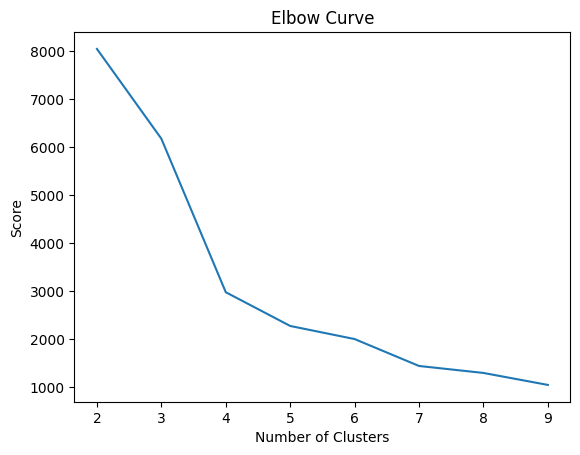

In [41]:
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

Building the K-Means Clustering Model

In [42]:
KMeans_algo=KMeans(featuresCol='standardized', k=4)
KMeans_fit=KMeans_algo.fit(data_scale_output)

Making predictions

In [43]:
preds=KMeans_fit.transform(data_scale_output)

preds.show(5,0)

+--------+---------+------------------+----------+------------------------------------+--------------------------------------------------------------+----------+
|recency |frequency|monetary_value    |CustomerID|features                            |standardized                                                  |prediction|
+--------+---------+------------------+----------+------------------------------------+--------------------------------------------------------------+----------+
|5580    |14       |226.14            |16250     |[5580.0,14.0,226.14]                |[4.565543463500656E-4,0.45450804304970116,0.07578116853200015]|0         |
|2704800 |121      |375.65            |15574     |[2704800.0,121.0,375.65]            |[0.22130612831678448,3.9282480863581313,0.12588306340782637]  |2         |
|54453660|20       |110.55000000000001|13610     |[5.445366E7,20.0,110.55000000000001]|[4.455386227180773,0.6492972043567159,0.037046113828657544]   |1         |
|54543900|47       |852.6800

Cluster analysis

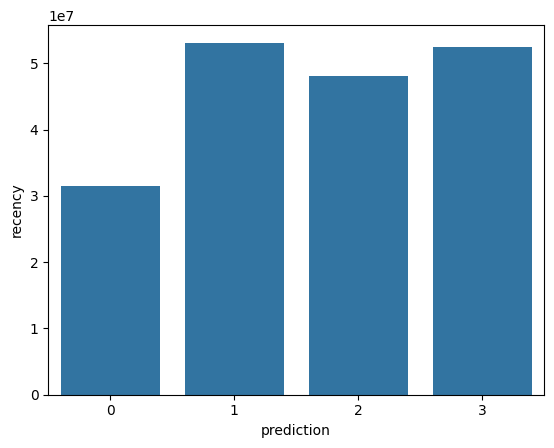

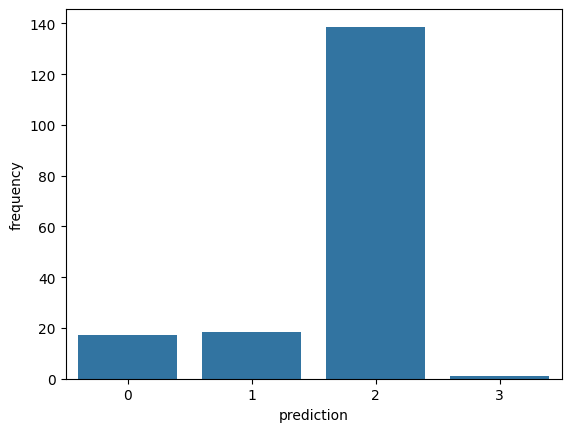

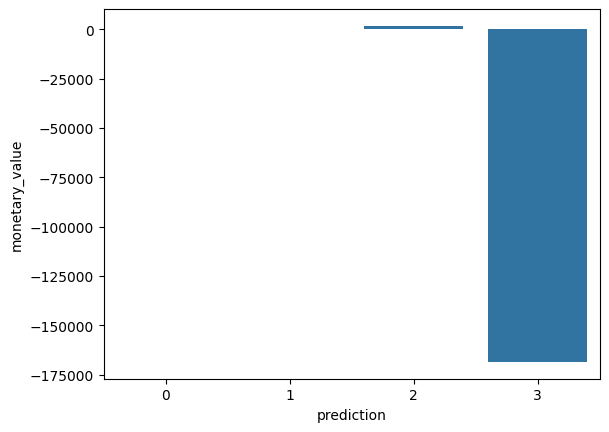

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()

### Cluster Analysis

Cluster 0:
Customers in this segment display low recency, frequency, and monetary value.
They rarely shop on the platform and are low potential customers.

Cluster 1:
Customer in this cluster display high recency but haven't been seen spending much on the platform.
They also don't visit the site often. This indicates that they might be newer customers who have just started doing business with the company.

Cluster 2:
Customers in this segment display medium recency and frequency and spend a lot of money on the platform. This indicates that they tend to buy high-value items or make bulk purchases.

Cluster 3:
The final segment comprises users who display high recency and make frequent purchases on the platform. However, they don't spend much on the platform, which might mean that they tend to select cheaper items in each purchase.